In [2]:
import numpy as np
import pandas as pd

pd.options.mode.chained_assignment = None  # default='warn'
import seaborn as sns

sns.set_theme()

#### setup db connection

In [3]:
from sqlalchemy import create_engine

def postgresql_engine(user, pwd, host, port, dbname):
    # Need psycopg2-binary package
    sql_engine = create_engine('postgres://' + user + ':' + pwd + '@' + host + ':' + port + '/' + dbname, echo=False)
    return sql_engine

In [4]:
# DB username & password
import getpass

username = getpass.getpass()
password = getpass.getpass()

In [5]:
# misc db parameters
url = 'adds-postgres-dev.cfgztrijqgvp.us-east-1.rds.amazonaws.com'
database = 'musiclab'
port = '5432'

In [6]:
# create DB engine
engine = postgresql_engine(username, password, url, port, database)

#### read in raw features from postgres DB

In [168]:
# read raw features table
query_raw_features = '''
Select *
from adds_temp.ebw_raw_features_h1 as eh
--where extract (year from eh.song_release_date) >= 2020
'''

with engine.connect() as conn:
    with conn.begin():
        df_raw_features = pd.read_sql(query_raw_features, con=conn)

In [169]:
# write to pickle file
# df_raw_features.to_pickle('ebw_df_raw_features_h1_from_psql.pkl')

In [170]:
df_raw_features.head()

,mediabase_id,song_id,call_letters,market_name,artist_id,format_code,song_release_date,first_callout_date,last_callout_date,first_spin_date,...,artist_format_spins_total,artist_format_spins_non_on,artist_format_spins_am_pm_dr,artist_market_spins_total,artist_market_spins_non_on,artist_market_spins_am_pm_dr,stream_count,completed_count,thumbs_up_count,thumbs_down_count
0,1086587,90090779,KHTS-FM,San Diego,26365333,H1,2022-06-01,2022-07-18,2023-01-02,2022-06-12,...,1340,1014,679,68,45,22,11852.0,8198.0,454.0,30.0
1,1086587,90090779,KHTS-FM,San Diego,26365333,H1,2022-06-01,2022-07-18,2023-01-02,2022-06-12,...,4095,2979,1895,96,62,31,12578.0,8658.0,464.0,20.0
2,1086587,90090779,KHTS-FM,San Diego,26365333,H1,2022-06-01,2022-07-18,2023-01-02,2022-06-12,...,6338,4556,3040,105,72,41,11914.0,8130.0,450.0,18.0
3,1086587,90090779,KHTS-FM,San Diego,26365333,H1,2022-06-01,2022-07-18,2023-01-02,2022-06-12,...,8085,5866,4019,121,94,57,22934.0,14218.0,720.0,44.0
4,1086587,90090779,KHTS-FM,San Diego,26365333,H1,2022-06-01,2022-07-18,2023-01-02,2022-06-12,...,10527,7655,5312,155,113,79,17184.0,11272.0,602.0,24.0


In [171]:
# read in pickle file
# df_raw_features = pd.read_pickle('ebw_df_raw_features_h1_from_psql.pkl')

In [172]:
# explicit cast for date related fields
date_cols = ['week_dt', 'song_release_date', 'hit_tag_date', 'first_spin_date', 'last_spin_date', 'ftq_date',
             'last_callout_date', 'first_callout_date']

df_raw_features[date_cols] = df_raw_features[date_cols].apply(pd.to_datetime)

In [173]:
# sort data
df_raw_features.sort_values(by=['mediabase_id', 'call_letters', 'week_dt'], inplace=True)

#### calculated fields

In [174]:
# Define a dictionary of computed columns to create
computed_cols = {
    'cuml_song_station_spins_non_on': lambda df: df.groupby(['mediabase_id', 'call_letters'])['song_station_spins_non_on'].cumsum(),
    'weeks_since_first_spins': lambda df: (df['week_dt'] - df['first_spin_date']) / np.timedelta64(1, 'W'),
    'weeks_since_release': lambda df: np.round((df['week_dt'] - df['song_release_date']) / np.timedelta64(1, 'W')),
    'weeks_since_hit': lambda df: (df['week_dt'] - df['hit_tag_date']) / np.timedelta64(1, 'W'),
    'weeks_bw_ftq_first_spins': lambda df: (df['ftq_date'] - df['first_spin_date']) / np.timedelta64(1, 'W'),
    'weeks_bw_top_quintiles': lambda df: (df['hit_tag_date'] - df['ftq_date']) / np.timedelta64(1, 'W'),
    'weeks_bw_ddl_thresh_cross': lambda df: (df['ddl_over_thresh_dt_second'] - df['ddl_over_thresh_dt_first']) / np.timedelta64(1, 'W'),
    'market_spins_propn': lambda df: df['song_station_spins_non_on'] / df['song_market_spins_non_on'],
    'artist_spins_propn': lambda df: df['song_station_spins_non_on'] / df['artist_station_spins_non_on'],
    'hit_tag_year': lambda df: df['hit_tag_date'].dt.year
}

# Use assign with a dictionary comprehension to create the computed columns
df_raw_features = df_raw_features.assign(**{col_name: func(df_raw_features) for col_name, func in computed_cols.items()})

In [175]:
# Define a sub-dataframe containing only the rows where week_dt equals hit_tag_date
mask = df_raw_features['week_dt'] == df_raw_features['hit_tag_date']
sub_df = df_raw_features.loc[mask, ['mediabase_id', 'call_letters', 'week_dt', 'cuml_song_station_spins_non_on']]
sub_df = sub_df.set_index(['mediabase_id', 'call_letters'])

# Join the sub-dataframe back onto the original dataframe
df_raw_features = df_raw_features.join(sub_df, on=['mediabase_id', 'call_letters'], rsuffix='_at_hit',
                                       how='left')

In [176]:
# Define a sub-dataframe containing only the rows where week_dt equals ftq_date
mask = df_raw_features['week_dt'] == df_raw_features['ftq_date']
sub_df = df_raw_features.loc[mask, ['mediabase_id', 'call_letters', 'week_dt', 'cuml_song_station_spins_non_on']]
sub_df = sub_df.set_index(['mediabase_id', 'call_letters'])

# Join the sub-dataframe back onto the original dataframe
df_raw_features = df_raw_features.join(sub_df, on=['mediabase_id', 'call_letters'], rsuffix='_at_ftq'
                                       , how='left')

In [177]:
# Filter rows where week_dt equals ddl_over_thresh_dt_first
mask = df_raw_features['week_dt'] == df_raw_features['ddl_over_thresh_dt_first']
sub_df = df_raw_features.loc[mask, ['mediabase_id', 'call_letters', 'week_dt', 'cuml_song_station_spins_non_on']]
sub_df = sub_df.set_index(['mediabase_id', 'call_letters'])

# Join sub-dataframe to original dataframe
df_raw_features = df_raw_features.join(sub_df, on=['mediabase_id', 'call_letters'], rsuffix='_at_pre_burnout',
                                       how='left')

In [178]:
# Filter rows where week_dt equals ddl_over_thresh_dt_second
mask = df_raw_features['week_dt'] == df_raw_features['ddl_over_thresh_dt_second']
sub_df = df_raw_features.loc[mask, ['mediabase_id', 'call_letters', 'week_dt', 'cuml_song_station_spins_non_on']]
sub_df = sub_df.set_index(['mediabase_id', 'call_letters'])

# Join sub-dataframe to original dataframe
df_raw_features = df_raw_features.join(sub_df, on=['mediabase_id', 'call_letters'], rsuffix='_at_burnout', how='left')

In [179]:
# measures spins to burnout after song turns into a hit
df_raw_features['spins_to_burnout_from_hit'] = df_raw_features['cuml_song_station_spins_non_on_at_burnout'] -\
                                               df_raw_features['cuml_song_station_spins_non_on_at_hit']

# measure spins to hit from ftq
df_raw_features['spins_to_hit_from_ftq'] = df_raw_features['cuml_song_station_spins_non_on_at_hit'] -\
                                           df_raw_features['cuml_song_station_spins_non_on_at_ftq']

In [180]:
df_raw_features['hit_spins_bucket'] = pd.cut(df_raw_features['cuml_song_station_spins_non_on_at_hit'], np.arange(0,
                                                                                                                 np.max(
                                                                                                                     df_raw_features[
                                                                                                                         'cuml_song_station_spins_non_on_at_hit']),
                                                                                                                 250))

In [181]:
# df_raw_features.drop(columns=['cuml_song_station_spins_non_on_at_hit'], inplace=True)

In [182]:
# df_raw_features['hit_spins_bucket']

In [183]:
# df_raw_features = pd.read_pickle('ebw_raw_features_base_h1.pkl')

In [184]:
query_all_spins = '''
Select *
from adds_temp.ebw_all_spins_h1 as esh
'''
with engine.connect() as conn:
    with conn.begin():
        df_all_spins = pd.read_sql(query_all_spins, conn)

In [185]:
all_spins_cols = ['market_spins_total', 'market_spins_non_on', 'market_spins_am_pm_dr', 'station_spins_total',
                  'station_spins_non_on', 'station_spins_am_pm_dr']
df_raw_features = df_raw_features.join(df_all_spins.set_index(['call_letters', 'week_dt'])[all_spins_cols],
                                       on=['call_letters', 'week_dt'])

In [186]:
df_raw_features.to_pickle('ebw_raw_features_base_h1.pkl')

In [187]:
# df_raw_features = pd.read_pickle('ebw_raw_features_base_h1.pkl')

#### extract unique hit information (spins/dates)

In [188]:
# de-dupe raw features to obtain unique hit info
id_cols = ['mediabase_id', 'call_letters']
date_cols = ['song_release_date', 'song_release_year', 'ftq_date', 'hit_tag_year', 'ddl_over_thresh_dt_first',
             'ddl_over_thresh_dt_second']
weeks_cols = ['weeks_bw_ftq_first_spins', 'weeks_bw_top_quintiles']
spins_cols = ['cuml_song_station_spins_non_on_at_ftq', 'cuml_song_station_spins_non_on_at_hit',
              'cuml_song_station_spins_non_on_at_pre_burnout', 'cuml_song_station_spins_non_on_at_burnout',
              'spins_to_hit_from_ftq', 'spins_to_burnout_from_hit']

# create dataframe with unique hit information
df_hits_tracker = df_raw_features[id_cols + date_cols + weeks_cols + spins_cols].drop_duplicates()

In [189]:
# df_hits_tracker.head()

In [190]:
# determine spins cutoff for end of burn monitoring
# df_hits_tracker.groupby(['song_release_year']).apply(lambda x: [len(x), np.nanquantile(x['spins_to_burnout_from_hit'], 0.05), np.nanquantile(x['spins_to_burnout_from_hit'], 0.95), (x['spins_to_burnout_from_hit'] > 2500).sum(),
#                                                                 # (x['spins_to_burnout_from_hit'] > 2500).sum() / len(x)])

In [191]:
# mask = df_hits_tracker['spins_to_burnout_from_hit'] < 150
# df_hits_tracker.loc[mask]

Based on the above information about 2-3% of the songs which experienced burnout in 2020 and 2021 took more than 2500 spins after turning into a hit. 2500 spins seems to be a reasonable cutoff for end of burnout monitoring

In [192]:
# # define censoring flag
# burn_end_spins_cutoff = 2500
# df_hits_tracker['censoring_flg'] = ~(pd.isna(df_hits_tracker['ddl_over_thresh_dt_second']) | (
#             df_hits_tracker['spins_to_burnout_from_hit'] > burn_end_spins_cutoff))

In [193]:
id_cols = ['mediabase_id','call_letters']
df_sub = df_raw_features.groupby(id_cols)['cuml_song_station_spins_non_on'].max().reset_index()
df_sub.columns = id_cols + ['cuml_song_station_spins_non_on_max']
df_hits_tracker = df_hits_tracker.join(df_sub.set_index(id_cols), on=id_cols)

In [194]:
id_cols = ['mediabase_id','call_letters']
df_sub = df_raw_features.groupby(id_cols)['cuml_song_station_spins_non_on'].max() - df_raw_features.groupby(id_cols)['cuml_song_station_spins_non_on_at_hit'].max()
df_sub = df_sub.reset_index()
df_sub.columns = id_cols + ['cuml_song_station_spins_non_on_since_hit_max']
df_hits_tracker = df_hits_tracker.join(df_sub.set_index(id_cols), on=id_cols)

In [195]:
# df_hits_tracker.head()

In [196]:
# df_hits_tracker['hit_tag_year'] = df_hits_tracker['hit_tag_date'].dt.year

In [197]:
# df_hits_tracker.groupby(['hit_tag_year'])['mediabase_id'].count()

In [198]:
# df_hits_tracker.boxplot(column=['cuml_song_station_spins_non_on_since_hit_max'], by=['hit_tag_year'])

In [199]:
df_hits_tracker['censoring_flg'] = False

In [200]:
# # censored due to too few spins
# mask = (df_hits_tracker['cuml_song_station_spins_non_on_max'] - df_hits_tracker['cuml_song_station_spins_non_on_at_hit'] < 2500) & (pd.isna(df_hits_tracker['ddl_over_thresh_dt_second']))
# # df_hits_tracker.loc[mask].groupby(['song_release_year'])['mediabase_id'].count()
# df_hits_tracker.loc[mask, 'censoring_flg'] = False
# df_hits_tracker.loc[mask, 'spins_to_burnout_from_hit'] = df_hits_tracker.loc[mask, 'cuml_song_station_spins_non_on_max'] - df_hits_tracker.loc[mask, 'cuml_song_station_spins_non_on_at_hit']

In [201]:
# df_hits_tracker

In [202]:
# # never experienced burnout
# mask = (df_hits_tracker['cuml_song_station_spins_non_on_max'] - df_hits_tracker['cuml_song_station_spins_non_on_at_hit'] > 2500) & (pd.isna(df_hits_tracker['ddl_over_thresh_dt_second']))
# # df_hits_tracker.loc[mask].groupby(['song_release_year'])['mediabase_id'].count()
# df_hits_tracker.loc[mask, 'censoring_flg'] = False
# df_hits_tracker.loc[mask, 'spins_to_burnout_from_hit'] = df_hits_tracker.loc[mask, 'cuml_song_station_spins_non_on_max'] - df_hits_tracker.loc[mask, 'cuml_song_station_spins_non_on_at_hit']

In [203]:
# # experienced burnout
# mask = (df_hits_tracker['cuml_song_station_spins_non_on_max'] - df_hits_tracker['cuml_song_station_spins_non_on_at_hit'] <= 2500) & (~pd.isna(df_hits_tracker['ddl_over_thresh_dt_second']))
# # df_hits_tracker.loc[mask].groupby(['song_release_year'])['mediabase_id'].count()
# df_hits_tracker.loc[mask, 'censoring_flg'] = True

In [204]:
# # experienced burnout but after 2500 spins
# mask = (df_hits_tracker['cuml_song_station_spins_non_on_max'] - df_hits_tracker['cuml_song_station_spins_non_on_at_hit'] > 2500) & (~pd.isna(df_hits_tracker['ddl_over_thresh_dt_second']))
# df_hits_tracker.loc[mask, 'censoring_flg'] = True
# # df_hits_tracker.loc[mask]

In [205]:
# df_hits_tracker

In [206]:
# df_hits_tracker.groupby(['song_release_year', 'censoring_flg'])['mediabase_id'].count()

In [207]:
df_hits_tracker.to_pickle('ebw_hits_tracker_h1.pkl')

In [208]:
# df_hits_tracker[['spins_to_burnout_from_hit', 'cuml_song_station_spins_non_on_since_hit_max']]

#### feature engineering

In [209]:
rolling_weeks = [1, 4, 8 ,13, 26]
lags = [1, 2, 3, 4]

In [210]:
song_sample_mask = df_raw_features['hit_tag_year'] >= 2020

##### pop score related columns

In [211]:
pop_cols = [col for col in df_raw_features.columns if
            (('_pop' in col) or ('_ddl' in col) or ('_fav' in col)) and ('weeks_' not in col)]

In [212]:
pop_cols

['song_station_pop',
 'song_station_ddl',
 'song_station_fav',
 'count_song_format_pop',
 'song_format_pop',
 'song_format_ddl',
 'song_format_fav',
 'count_artist_format_pop',
 'artist_format_pop',
 'artist_format_ddl',
 'artist_format_fav']

##### rolling statistics look back

In [213]:
df_raw_features[pop_cols].columns

Index(['song_station_pop', 'song_station_ddl', 'song_station_fav',
       'count_song_format_pop', 'song_format_pop', 'song_format_ddl',
       'song_format_fav', 'count_artist_format_pop', 'artist_format_pop',
       'artist_format_ddl', 'artist_format_fav'],
      dtype='object')

array([[<AxesSubplot:title={'center':'song_station_pop'}>,
        <AxesSubplot:title={'center':'song_station_ddl'}>,
        <AxesSubplot:title={'center':'song_station_fav'}>],
       [<AxesSubplot:title={'center':'count_song_format_pop'}>,
        <AxesSubplot:title={'center':'song_format_pop'}>,
        <AxesSubplot:title={'center':'song_format_ddl'}>],
       [<AxesSubplot:title={'center':'song_format_fav'}>,
        <AxesSubplot:title={'center':'count_artist_format_pop'}>,
        <AxesSubplot:title={'center':'artist_format_pop'}>],
       [<AxesSubplot:title={'center':'artist_format_ddl'}>,
        <AxesSubplot:title={'center':'artist_format_fav'}>,
        <AxesSubplot:>]], dtype=object)

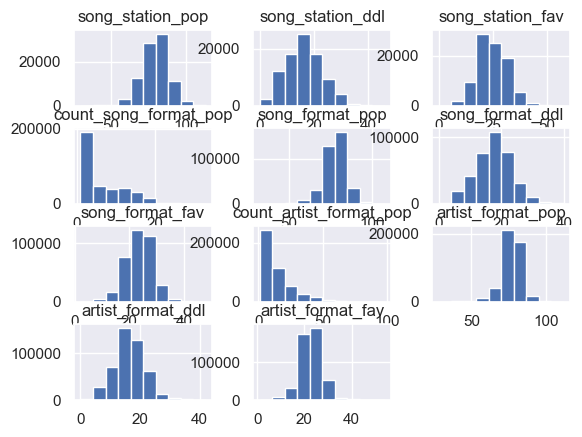

In [214]:
df_raw_features[pop_cols].hist()

In [215]:
id_cols = ['mediabase_id', 'call_letters', 'week_dt', 'weeks_since_hit']
df_pop_features = df_raw_features[id_cols]
for win_len in rolling_weeks:
    for lag in lags:
        for col in pop_cols:
            col_name = f"{col}_{win_len}wk_lag{lag}"
            roll_col = df_raw_features.loc[song_sample_mask].groupby(['mediabase_id', 'call_letters'])[col].rolling(window=win_len, min_periods=0)
            df_pop_features[f"{col_name}_min"] = (roll_col.min().shift(lag).droplevel([0,1])).ffill()
            df_pop_features[f"{col_name}_max"] = (roll_col.max().shift(lag).droplevel([0,1])).ffill()
            df_pop_features[f"{col_name}_mean"] = (roll_col.mean().shift(lag).droplevel([0,1])).ffill()
            df_pop_features[f"{col_name}_std"] = (roll_col.std().shift(lag).droplevel([0,1])).ffill()

In [216]:
df_pop_features.shape

(656708, 884)

In [217]:
df_pop_features.to_pickle('ebw_pop_features_h1.pkl')

In [218]:
# df_pop_features[df_pop_features['weeks_since_hit'] > 0]

In [219]:
# import matplotlib.pyplot as plt
# mask = (df_raw_features['mediabase_id'] == 1086587) & (df_raw_features['call_letters'] == 'KHTS-FM')
# sel_cols = ['song_format_pop','song_format_pop_4wk_lag1_mean', 'song_format_pop_4wk_lag2_mean', 'song_format_pop_4wk_lag3_mean', 'song_format_pop_4wk_lag4_mean', 'song_format_pop_1wk_lag1_mean']
# plt.scatter(df_raw_features.loc[mask, 'week_dt'], df_raw_features.loc[mask, sel_cols[0]], label=sel_cols[0])
# # plt.plot(df_raw_features.loc[mask, 'week_dt'], df_raw_features.loc[mask, sel_cols[1]], label=sel_cols[1])
# plt.plot(df_raw_features.loc[mask, 'week_dt'], df_raw_features.loc[mask, sel_cols[2]], label=sel_cols[2])
# plt.plot(df_raw_features.loc[mask, 'week_dt'], df_raw_features.loc[mask, sel_cols[3]], label=sel_cols[3])
# plt.plot(df_raw_features.loc[mask, 'week_dt'], df_raw_features.loc[mask, sel_cols[4]], label=sel_cols[4])
# plt.plot(df_raw_features.loc[mask, 'week_dt'], df_raw_features.loc[mask, sel_cols[5]], label=sel_cols[5])
# plt.legend()

##### rolling stats from ftq to hit


In [220]:
# for col in pop_cols:
#     col_name = f"{col}_ftq_to_hit"
#     col_names = [f"{col_name}_min", f"{col_name}_max", f"{col_name}_mean", f"{col_name}_std"]
#     mask = (df_raw_features['week_dt'] >= df_raw_features['week_dt_at_ftq']) & (
#             df_raw_features['week_dt'] <= df_raw_features['week_dt_at_hit'])
#     df_sub = df_raw_features.loc[mask]
#     df_sub_grpd = df_sub.groupby(['mediabase_id', 'call_letters'])[col]
#     df_temp = pd.concat([df_sub_grpd.min(), df_sub_grpd.max(), df_sub_grpd.mean(), df_sub_grpd.std()], axis=1)
#     df_temp.columns=col_names
#     df_raw_features = df_raw_features.join(df_temp, on =['mediabase_id', 'call_letters'], how='left')

##### spins related information

In [221]:
spins_cols = [col for col in df_raw_features.columns if
              ('_spins' in col) and ('cuml_' not in col) and ('_bucket' not in col) and ('_propn' not in col) and (
                      'weeks_' not in col)]

In [222]:
spins_cols

['song_station_spins_total',
 'song_station_spins_non_on',
 'song_station_spins_am_pm_dr',
 'song_format_spins_total',
 'song_format_spins_non_on',
 'song_format_spins_am_pm_dr',
 'song_market_spins_total',
 'song_market_spins_non_on',
 'song_market_spins_am_pm_dr',
 'artist_station_spins_total',
 'artist_station_spins_non_on',
 'artist_station_spins_am_pm_dr',
 'artist_format_spins_total',
 'artist_format_spins_non_on',
 'artist_format_spins_am_pm_dr',
 'artist_market_spins_total',
 'artist_market_spins_non_on',
 'artist_market_spins_am_pm_dr',
 'market_spins_total',
 'market_spins_non_on',
 'market_spins_am_pm_dr',
 'station_spins_total',
 'station_spins_non_on',
 'station_spins_am_pm_dr']

##### rolling statistics look back

In [223]:
# df_raw_features[spins_cols].hist(figsize=(16,12), bins=100)

In [224]:
# list((set(spins_cols) - set(all_spins_cols)) - set([col for col in spins_cols if 'total' in col]))

In [225]:
id_cols = ['mediabase_id', 'call_letters', 'week_dt', 'weeks_since_hit']
df_spins_features = df_raw_features[id_cols]
for win_len in rolling_weeks:
    for lag in lags:
        for col in list((set(spins_cols) - set(all_spins_cols)) - set([col for col in spins_cols if 'total' in col])):
            col_name = f"{col}_{win_len}wk_lag{lag}"
            roll_col = df_raw_features.loc[song_sample_mask].groupby(['mediabase_id', 'call_letters'])[col].rolling(window=win_len,
                                                                                              min_periods=0)
            df_spins_features[f"{col_name}_sum"] = (roll_col.sum().shift(lag).droplevel([0, 1])).ffill()
            df_spins_features[f"{col_name}_min"] = (roll_col.min().shift(lag).droplevel([0, 1])).ffill()
            df_spins_features[f"{col_name}_max"] = (roll_col.max().shift(lag).droplevel([0, 1])).ffill()
            df_spins_features[f"{col_name}_mean"] = (roll_col.mean().shift(lag).droplevel([0, 1])).ffill()
            df_spins_features[f"{col_name}_std"] = (roll_col.std().shift(lag).droplevel([0, 1])).ffill()

In [226]:
id_cols = ['mediabase_id', 'call_letters', 'week_dt', 'weeks_since_hit']
df_all_spins_features = df_raw_features[id_cols]
for win_len in rolling_weeks:
    for lag in lags:
        for col in spins_cols:
            col_name = f"{col}_{win_len}wk_lag{lag}"
            roll_col = df_raw_features.loc[song_sample_mask].groupby(['mediabase_id', 'call_letters'])[col].rolling(window=win_len,
                                                                                              min_periods=0)
            if col in all_spins_cols:
                df_all_spins_features[f"{col_name}_sum"] = (roll_col.sum().shift(lag).droplevel([0, 1])).ffill()

In [227]:
# df_spins_features.shape

In [228]:
df_spins_features.to_pickle('ebw_spins_features_h1.pkl')

In [229]:
df_all_spins_features.to_pickle('ebw_all_spins_features_h1.pkl')

In [142]:
# df_spins_features.shape

(656708, 1204)

##### rolling stats from ftq to hit


In [75]:
# for col in spins_cols:
#     col_name = f"{col}_ftq_to_hit"
#     col_names = [f"{col_name}_min", f"{col_name}_max", f"{col_name}_mean", f"{col_name}_std"]
#     mask = (df_raw_features['week_dt'] >= df_raw_features['week_dt_at_ftq']) & (
#             df_raw_features['week_dt'] <= df_raw_features['week_dt_at_hit'])
#     df_sub = df_raw_features.loc[mask]
#     df_sub_grpd = df_sub.groupby(['mediabase_id', 'call_letters'])[col]
#     df_temp = pd.concat([df_sub_grpd.min(), df_sub_grpd.max(), df_sub_grpd.mean(), df_sub_grpd.std()], axis=1)
#     df_temp.columns=col_names
#     df_raw_features = df_raw_features.join(df_temp, on =['mediabase_id', 'call_letters'], how='left')

##### stream related data

In [230]:
stream_cols = [col for col in df_raw_features.columns if '_count' in col]

In [231]:
stream_cols

['stream_count', 'completed_count', 'thumbs_up_count', 'thumbs_down_count']

array([[<AxesSubplot:title={'center':'stream_count'}>,
        <AxesSubplot:title={'center':'completed_count'}>],
       [<AxesSubplot:title={'center':'thumbs_up_count'}>,
        <AxesSubplot:title={'center':'thumbs_down_count'}>]], dtype=object)

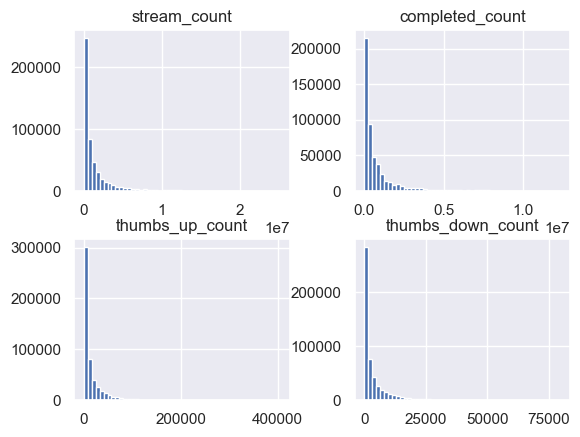

In [234]:
df_raw_features[stream_cols].hist(bins=50)

In [235]:
id_cols = ['mediabase_id', 'call_letters', 'week_dt', 'weeks_since_hit']
df_streams_features = df_raw_features[id_cols]
for win_len in rolling_weeks:
    for lag in lags:
        for col in stream_cols:
            col_name = f"{col}_{win_len}wk_lag{lag}"
            roll_col = df_raw_features.loc[song_sample_mask].groupby(['mediabase_id', 'call_letters'])[col].rolling(
                window=win_len,
                min_periods=0)
            df_streams_features[f"{col_name}_sum"] = (roll_col.sum().shift(lag).droplevel([0, 1])).ffill()
            df_streams_features[f"{col_name}_min"] = (roll_col.min().shift(lag).droplevel([0, 1])).ffill()
            df_streams_features[f"{col_name}_max"] = (roll_col.max().shift(lag).droplevel([0, 1])).ffill()
            df_streams_features[f"{col_name}_mean"] = (roll_col.mean().shift(lag).droplevel([0, 1])).ffill()
            df_streams_features[f"{col_name}_std"] = (roll_col.std().shift(lag).droplevel([0, 1])).ffill()

In [238]:
df_raw_features['thumbs_all_count'] = df_raw_features['thumbs_up_count'] + df_raw_features['thumbs_down_count']

In [240]:
for win_len in rolling_weeks:
    roll_col_grp = df_raw_features.loc[song_sample_mask].groupby(['mediabase_id', 'call_letters'])
    df_streams_features[f'completed_rate_{win_len}wk'] = (roll_col_grp['completed_count'].rolling(
        window=win_len,
        min_periods=0).sum().droplevel([0, 1]).ffill() / roll_col_grp['stream_count'].rolling(
        window=win_len,
        min_periods=0).sum().droplevel([0, 1]).ffill())
    df_streams_features[f'thumbs_up_rate_{win_len}wk'] = (roll_col_grp['thumbs_up_count'].rolling(
        window=win_len,
        min_periods=0).sum().droplevel([0, 1]).ffill() / (roll_col_grp['thumbs_all_count']).rolling(
        window=win_len,
        min_periods=0).sum().droplevel([0, 1]).ffill())
    df_streams_features[f'thumbs_up_rate_total_{win_len}wk'] = (roll_col_grp['thumbs_up_count'].rolling(
        window=win_len,
        min_periods=0).sum().droplevel([0, 1]).ffill() / (roll_col_grp['stream_count']).rolling(
        window=win_len,
        min_periods=0).sum().droplevel([0, 1]).ffill())

In [241]:
df_streams_features

,mediabase_id,call_letters,week_dt,weeks_since_hit,stream_count_1wk_lag1_sum,stream_count_1wk_lag1_min,stream_count_1wk_lag1_max,stream_count_1wk_lag1_mean,stream_count_1wk_lag1_std,completed_count_1wk_lag1_sum,...,thumbs_up_rate_total_4wk,completed_rate_8wk,thumbs_up_rate_8wk,thumbs_up_rate_total_8wk,completed_rate_13wk,thumbs_up_rate_13wk,thumbs_up_rate_total_13wk,completed_rate_26wk,thumbs_up_rate_26wk,thumbs_up_rate_total_26wk
0,1086587,KHTS-FM,2022-06-12,-19.0,NaN,NaN,NaN,NaN,NaN,NaN,...,0.038306,0.691698,0.938017,0.038306,0.691698,0.938017,0.038306,0.691698,0.938017,0.038306
1,1086587,KHTS-FM,2022-06-19,-18.0,11852.0,11852.0,11852.0,11852.0,NaN,8198.0,...,0.037577,0.689971,0.948347,0.037577,0.689971,0.948347,0.037577,0.689971,0.948347,0.037577
2,1086587,KHTS-FM,2022-06-26,-17.0,12578.0,12578.0,12578.0,12578.0,NaN,8658.0,...,0.037640,0.687486,0.952646,0.037640,0.687486,0.952646,0.037640,0.687486,0.952646,0.037640
3,1086587,KHTS-FM,2022-07-03,-16.0,11914.0,11914.0,11914.0,11914.0,NaN,8130.0,...,0.035224,0.661358,0.949091,0.035224,0.661358,0.949091,0.035224,0.661358,0.949091,0.035224
4,1086587,KHTS-FM,2022-07-10,-15.0,22934.0,22934.0,22934.0,22934.0,NaN,14218.0,...,0.034608,0.660145,0.951875,0.035181,0.660145,0.951875,0.035181,0.660145,0.951875,0.035181
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
656703,2865765,WZFT-FM,2023-02-26,3.0,0.0,6.0,6.0,6.0,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
656704,2865765,WZFT-FM,2023-03-05,4.0,0.0,6.0,6.0,6.0,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
656705,2865765,WZFT-FM,2023-03-12,5.0,0.0,6.0,6.0,6.0,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
656706,2865765,WZFT-FM,2023-03-19,6.0,0.0,6.0,6.0,6.0,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [242]:
df_streams_features.to_pickle('ebw_streams_features_h1.pkl')

##### rolling statistics look back

In [ ]:
# for win_len in rolling_weeks:
#     for lag in lags:
#         for col in stream_cols:
#             col_name = f"{col}_prior_{win_len}wk_lag{lag}"
#             roll_col = df_raw_features.groupby(['mediabase_id', 'call_letters'])[col].rolling(window=win_len, min_periods=0)
#             df_raw_features[f"{col_name}_min"] = (roll_col.min().shift(lag).droplevel([0,1])).ffill()
#             df_raw_features[f"{col_name}_max"] = (roll_col.max().shift(lag).droplevel([0,1])).ffill()
#             df_raw_features[f"{col_name}_mean"] = (roll_col.mean().shift(lag).droplevel([0,1])).ffill()
#             # df_raw_features[f"{col_name}_std"] = (roll_col.std().shift(1).droplevel([0,1])).ffill()

##### rolling stats from ftq to hit


In [79]:
# for col in stream_cols:
#     col_name = f"{col}_ftq_to_hit"
#     col_names = [f"{col_name}_min", f"{col_name}_max", f"{col_name}_mean", f"{col_name}_std"]
#     mask = (df_raw_features['week_dt'] >= df_raw_features['week_dt_at_ftq']) & (
#             df_raw_features['week_dt'] <= df_raw_features['week_dt_at_hit'])
#     df_sub = df_raw_features.loc[mask]
#     df_sub_grpd = df_sub.groupby(['mediabase_id', 'call_letters'])[col]
#     df_temp = pd.concat([df_sub_grpd.min(), df_sub_grpd.max(), df_sub_grpd.mean(), df_sub_grpd.std()], axis=1)
#     df_temp.columns=col_names
#     df_raw_features = df_raw_features.join(df_temp, on =['mediabase_id', 'call_letters'], how='left')

##### proportion related data

In [23]:
[ col for col in df_spins_features.columns if ('_sum' in col) and (('song_station_spins_non_on' in col) or ('song_market_spins_non_on' in col))]

['song_station_spins_non_on_1wk_lag1_sum',
 'song_market_spins_non_on_1wk_lag1_sum',
 'song_station_spins_non_on_1wk_lag2_sum',
 'song_market_spins_non_on_1wk_lag2_sum',
 'song_station_spins_non_on_1wk_lag3_sum',
 'song_market_spins_non_on_1wk_lag3_sum',
 'song_station_spins_non_on_1wk_lag4_sum',
 'song_market_spins_non_on_1wk_lag4_sum',
 'song_station_spins_non_on_4wk_lag1_sum',
 'song_market_spins_non_on_4wk_lag1_sum',
 'song_station_spins_non_on_4wk_lag2_sum',
 'song_market_spins_non_on_4wk_lag2_sum',
 'song_station_spins_non_on_4wk_lag3_sum',
 'song_market_spins_non_on_4wk_lag3_sum',
 'song_station_spins_non_on_4wk_lag4_sum',
 'song_market_spins_non_on_4wk_lag4_sum',
 'song_station_spins_non_on_8wk_lag1_sum',
 'song_market_spins_non_on_8wk_lag1_sum',
 'song_station_spins_non_on_8wk_lag2_sum',
 'song_market_spins_non_on_8wk_lag2_sum',
 'song_station_spins_non_on_8wk_lag3_sum',
 'song_market_spins_non_on_8wk_lag3_sum',
 'song_station_spins_non_on_8wk_lag4_sum',
 'song_market_spins_no

In [80]:
propn_cols = [col for col in df_raw_features.columns if 'propn' in col]

In [81]:
propn_cols

['market_spins_propn', 'artist_spins_propn']

In [28]:
df_spins_features.shape

(656339, 1804)

In [31]:
df_test = df_spins_features.set_index(['call_letters', 'mediabase_id', 'week_dt'])['song_station_spins_non_on_1wk_lag1_sum']/df_spins_features.groupby(['call_letters', 'week_dt'])['song_station_spins_non_on_1wk_lag1_sum'].sum()

In [36]:
df_spins_features

,mediabase_id,call_letters,week_dt,weeks_since_hit,song_station_spins_total_1wk_lag1_sum,song_station_spins_total_1wk_lag1_min,song_station_spins_total_1wk_lag1_max,song_station_spins_total_1wk_lag1_mean,song_station_spins_total_1wk_lag1_std,song_station_spins_non_on_1wk_lag1_sum,...,artist_market_spins_non_on_26wk_lag4_sum,artist_market_spins_non_on_26wk_lag4_min,artist_market_spins_non_on_26wk_lag4_max,artist_market_spins_non_on_26wk_lag4_mean,artist_market_spins_non_on_26wk_lag4_std,artist_market_spins_am_pm_dr_26wk_lag4_sum,artist_market_spins_am_pm_dr_26wk_lag4_min,artist_market_spins_am_pm_dr_26wk_lag4_max,artist_market_spins_am_pm_dr_26wk_lag4_mean,artist_market_spins_am_pm_dr_26wk_lag4_std
0,1086587,KHTS-FM,2022-06-12,-19.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1086587,KHTS-FM,2022-06-19,-18.0,17.0,17.0,17.0,17.0,NaN,11.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1086587,KHTS-FM,2022-06-26,-17.0,30.0,30.0,30.0,30.0,NaN,16.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1086587,KHTS-FM,2022-07-03,-16.0,29.0,29.0,29.0,29.0,NaN,19.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1086587,KHTS-FM,2022-07-10,-15.0,37.0,37.0,37.0,37.0,NaN,31.0,...,45.0,45.0,45.0,45.000000,NaN,22.0,22.0,22.0,22.000000,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
656334,2865765,WZFT-FM,2023-02-26,3.0,108.0,108.0,108.0,108.0,NaN,80.0,...,447.0,31.0,139.0,89.400000,46.182248,312.0,22.0,91.0,62.400000,31.572140
656335,2865765,WZFT-FM,2023-03-05,4.0,121.0,121.0,121.0,121.0,NaN,91.0,...,606.0,31.0,159.0,101.000000,50.135816,416.0,22.0,104.0,69.333333,32.952491
656336,2865765,WZFT-FM,2023-03-12,5.0,129.0,129.0,129.0,129.0,NaN,97.0,...,767.0,31.0,161.0,109.571429,51.077905,522.0,22.0,106.0,74.571429,33.120271
656337,2865765,WZFT-FM,2023-03-19,6.0,121.0,121.0,121.0,121.0,NaN,91.0,...,948.0,31.0,181.0,118.500000,53.609701,650.0,22.0,128.0,81.250000,36.014878


In [243]:
id_cols = ['mediabase_id', 'call_letters', 'week_dt', 'weeks_since_hit']
df_spins_propn_features = df_raw_features[id_cols]
for win_len in rolling_weeks:
    for lag in lags:
        df_spins_propn_features[f'song_station_share_{win_len}wk_lag{lag}'] = df_spins_features[f'song_station_spins_non_on_{win_len}wk_lag{lag}_sum']/df_all_spins_features[f'station_spins_non_on_{win_len}wk_lag{lag}_sum']
        df_spins_propn_features[f'artist_station_share_{win_len}wk_lag{lag}'] = df_spins_features[f'artist_station_spins_non_on_{win_len}wk_lag{lag}_sum']/df_all_spins_features[f'station_spins_non_on_{win_len}wk_lag{lag}_sum']
        df_spins_propn_features[f'song_market_share_{win_len}wk_lag{lag}'] = df_spins_features[f'song_market_spins_non_on_{win_len}wk_lag{lag}_sum']/df_all_spins_features[f'market_spins_non_on_{win_len}wk_lag{lag}_sum']
        df_spins_propn_features[f'artist_market_share_{win_len}wk_lag{lag}'] = df_spins_features[f'artist_market_spins_non_on_{win_len}wk_lag{lag}_sum']/df_all_spins_features[f'market_spins_non_on_{win_len}wk_lag{lag}_sum']
        # df_spins_propn_features[f'song_station_market_share_{win_len}wk_lag{lag}'] = df_spins_features[f'song_station_spins_non_on_{win_len}wk_lag{lag}_sum']/df_spins_features[f'song_market_spins_non_on_{win_len}wk_lag1_sum']
        # df_spins_propn_features[f'song_artist_station_share_{win_len}wk_lag{lag}'] = df_spins_features[f'song_station_spins_non_on_{win_len}wk_lag{lag}_sum']/df_spins_features[f'artist_station_spins_non_on_{win_len}wk_lag1_sum']

In [244]:
df_spins_features.loc[0][['song_station_spins_non_on_1wk_lag1_sum', 'song_market_spins_non_on_1wk_lag1_sum']]

song_station_spins_non_on_1wk_lag1_sum    NaN
song_market_spins_non_on_1wk_lag1_sum     NaN
Name: 0, dtype: object

In [59]:
df_spins_propn_features.describe()

,mediabase_id,weeks_since_hit,song_station_share_1wk_lag1,artist_station_share_1wk_lag1,song_market_share_1wk_lag1,artist_market_share_1wk_lag1,song_station_share_1wk_lag2,artist_station_share_1wk_lag2,song_market_share_1wk_lag2,artist_market_share_1wk_lag2,...,song_market_share_26wk_lag2,artist_market_share_26wk_lag2,song_station_share_26wk_lag3,artist_station_share_26wk_lag3,song_market_share_26wk_lag3,artist_market_share_26wk_lag3,song_station_share_26wk_lag4,artist_station_share_26wk_lag4,song_market_share_26wk_lag4,artist_market_share_26wk_lag4
count,6.563390e+05,656339.000000,656338.000000,656338.000000,656338.000000,656338.000000,656337.000000,656337.000000,656337.000000,656337.000000,...,656337.000000,656337.000000,656336.000000,656336.000000,656336.000000,656336.000000,656335.000000,656335.000000,656335.000000,656335.000000
mean,2.425751e+06,93.443221,0.007221,0.018340,0.001298,0.003461,0.007221,0.018340,0.001298,0.003461,...,0.001408,0.003641,0.007928,0.019519,0.001408,0.003641,0.007928,0.019519,0.001408,0.003641
std,1.409448e+05,82.006548,0.013682,0.026579,0.002027,0.003991,0.013682,0.026579,0.002027,0.003991,...,0.001864,0.003815,0.011914,0.024847,0.001864,0.003815,0.011914,0.024847,0.001864,0.003815
min,1.086587e+06,-291.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.305938e+06,26.000000,0.000000,0.000000,0.000075,0.000459,0.000000,0.000000,0.000075,0.000459,...,0.000143,0.000642,0.000052,0.001201,0.000143,0.000642,0.000052,0.001201,0.000143,0.000642
50%,2.393994e+06,82.000000,0.000623,0.005675,0.000449,0.001958,0.000623,0.005675,0.000449,0.001958,...,0.000584,0.002352,0.001852,0.009084,0.000584,0.002352,0.001852,0.009084,0.000584,0.002352
75%,2.522450e+06,153.000000,0.006854,0.026555,0.001514,0.005183,0.006854,0.026555,0.001514,0.005183,...,0.001950,0.005513,0.010972,0.029883,0.001950,0.005513,0.010972,0.029883,0.001950,0.005513
max,2.865765e+06,322.000000,0.076466,0.194773,0.023200,0.030342,0.076466,0.194773,0.023200,0.030342,...,0.019100,0.026437,0.063313,0.189623,0.019100,0.026437,0.063313,0.189623,0.019100,0.026437


In [309]:
df_spins_propn_features

,mediabase_id,call_letters,week_dt,weeks_since_hit,song_station_share_1wk_lag1,artist_station_share_1wk_lag1,song_market_share_1wk_lag1,artist_market_share_1wk_lag1,song_station_share_1wk_lag2,artist_station_share_1wk_lag2,...,song_market_share_26wk_lag2,artist_market_share_26wk_lag2,song_station_share_26wk_lag3,artist_station_share_26wk_lag3,song_market_share_26wk_lag3,artist_market_share_26wk_lag3,song_station_share_26wk_lag4,artist_station_share_26wk_lag4,song_market_share_26wk_lag4,artist_market_share_26wk_lag4
0,1086587,KHTS-FM,2022-06-12,-19.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1086587,KHTS-FM,2022-06-19,-18.0,0.006087,0.006087,0.001392,0.001423,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1086587,KHTS-FM,2022-06-26,-17.0,0.008919,0.008919,0.001893,0.001956,0.006087,0.006087,...,0.001392,0.001423,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1086587,KHTS-FM,2022-07-03,-16.0,0.010615,0.010615,0.002025,0.002243,0.008919,0.008919,...,0.001643,0.001690,0.006087,0.006087,0.001392,0.001423,NaN,NaN,NaN,NaN
4,1086587,KHTS-FM,2022-07-10,-15.0,0.016631,0.016631,0.002639,0.002851,0.010615,0.010615,...,0.001771,0.001876,0.007498,0.007498,0.001643,0.001690,0.006087,0.006087,0.001392,0.001423
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
656703,2865765,WZFT-FM,2023-02-26,3.0,0.048106,0.072760,0.005337,0.009660,0.047001,0.058132,...,0.003062,0.005338,0.024797,0.030971,0.002745,0.004850,0.021234,0.026835,0.002325,0.004259
656704,2865765,WZFT-FM,2023-03-05,4.0,0.056104,0.098027,0.006118,0.012289,0.048106,0.072760,...,0.003324,0.005836,0.027834,0.034687,0.003062,0.005338,0.024797,0.030971,0.002745,0.004850
656705,2865765,WZFT-FM,2023-03-12,5.0,0.059473,0.092581,0.007125,0.012283,0.056104,0.098027,...,0.003616,0.006511,0.030334,0.039383,0.003324,0.005836,0.027834,0.034687,0.003062,0.005338
656706,2865765,WZFT-FM,2023-03-19,6.0,0.056627,0.084007,0.006559,0.011506,0.059473,0.092581,...,0.003946,0.007053,0.033102,0.045680,0.003616,0.006511,0.030334,0.039383,0.003324,0.005836


In [245]:
df_spins_propn_features.to_pickle('ebw_propn_features_h1.pkl')

##### rolling statistics look back

##### rolling stats from ftq to hit


In [83]:
# for col in propn_cols:
#     col_name = f"{col}_ftq_to_hit"
#     col_names = [f"{col_name}_min", f"{col_name}_max", f"{col_name}_mean", f"{col_name}_std"]
#     mask = (df_raw_features['week_dt'] >= df_raw_features['week_dt_at_ftq']) & (
#             df_raw_features['week_dt'] <= df_raw_features['week_dt_at_hit'])
#     df_sub = df_raw_features.loc[mask]
#     df_sub_grpd = df_sub.groupby(['mediabase_id', 'call_letters'])[col]
#     df_temp = pd.concat([df_sub_grpd.min(), df_sub_grpd.max(), df_sub_grpd.mean(), df_sub_grpd.std()], axis=1)
#     df_temp.columns=col_names
#     df_raw_features = df_raw_features.join(df_temp, on =['mediabase_id', 'call_letters'], how='left')

In [70]:
df_raw_features.shape

(675941, 3644)

In [ ]:
# propogate censoring flag back to raw features
join_cols = ['mediabase_id', 'call_letters']
df_sub = df_hits_tracker.set_index(join_cols)['censoring_flg']

df_raw_features = df_raw_features.join(df_sub, on=join_cols, how='left')

In [71]:
df_hits_tracker.to_pickle('ebw_hits_tracker_h1.pkl')
df_raw_features.to_pickle('ebw_temp_features_h1.pkl')

In [3]:
import pandas as pd
df_hits_tracker = pd.read_pickle('ebw_hits_tracker_h1.pkl')

In [ ]:
# import pandas as pd
# df_raw_features = pd.read_pickle('ebw_temp_features_h1.pkl')
# df_hits_tracker = pd.read_pickle('ebw_hits_tracker_h1.pkl')

ValueError: The number of FixedLocator locations (2), usually from a call to set_ticks, does not match the number of ticklabels (1).

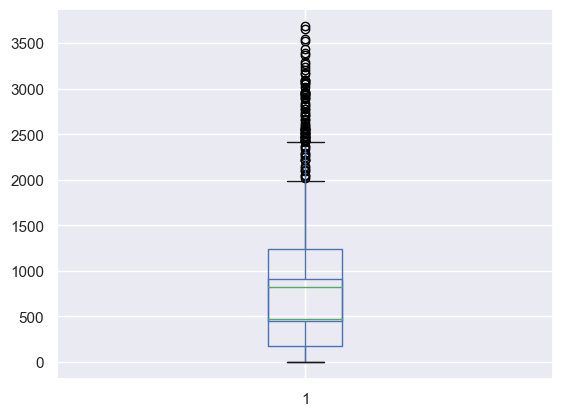

In [223]:
df_hits_tracker.groupby(['censoring_flg'])['spins_to_burnout_from_hit'].plot(kind='box')

In [5]:
import seaborn as sns

<AxesSubplot:xlabel='censoring_flg', ylabel='spins_to_burnout_from_hit'>

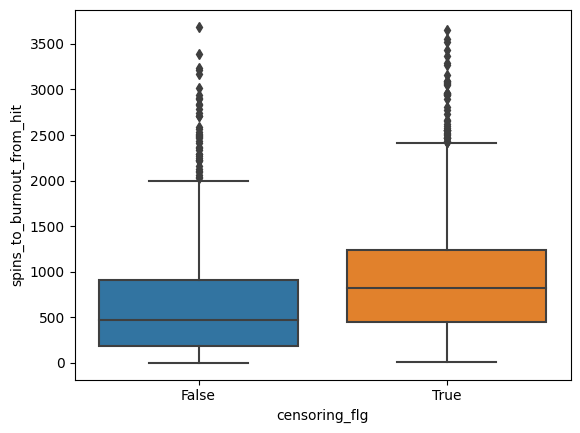

In [6]:
sns.boxplot(x='censoring_flg', y='spins_to_burnout_from_hit', data=df_hits_tracker)

<AxesSubplot:ylabel='Frequency'>

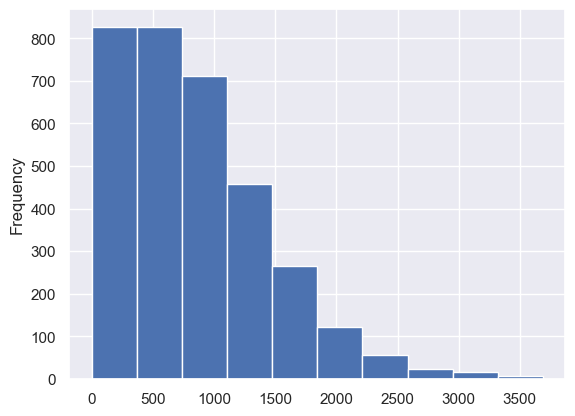

In [214]:
df_hits_tracker['spins_to_burnout_from_hit'].plot(kind='hist')

In [9]:
pd.to_datetime(df_hits_tracker['ddl_over_thresh_dt_second']) - df_hits_tracker['hit_tag_date']

0        28 days
42           NaT
84           NaT
127          NaT
169      49 days
           ...  
656542       NaT
656555       NaT
656568       NaT
656581       NaT
656594       NaT
Length: 3384, dtype: timedelta64[ns]

#### create percentage delta features

In [246]:
feature_types = ['pop', 'spins']
id_cols = ['mediabase_id', 'call_letters', 'week_dt', 'weeks_since_hit']
df_pct_chg_features = df_raw_features[id_cols]
for typ in feature_types:
    df_temp_features = pd.read_pickle(f'ebw_{typ}_features_h1.pkl')
    df_temp_features.sort_values(by=['mediabase_id', 'call_letters', 'week_dt'], inplace=True)
    change_cols = list(set([col for col in df_temp_features.columns if '1wk' in col]) - set([col for col in df_temp_features.columns if 'std' in col]))
    for col in change_cols:
        df_pct_chg_features[col + '_pct_chg'] = df_temp_features.groupby(['mediabase_id', 'call_letters'])[col].pct_change().replace([np.inf], 1.0).replace([-np.inf], -1.0).fillna(0)

In [247]:
df_pct_chg_features.shape

(656708, 328)

In [248]:
df_pct_chg_features.to_pickle('ebw_pctchg_features_h1.pkl')

In [249]:
df_pct_chg_features.columns

Index(['mediabase_id', 'call_letters', 'week_dt', 'weeks_since_hit',
       'artist_format_ddl_1wk_lag2_min_pct_chg',
       'artist_format_ddl_1wk_lag4_mean_pct_chg',
       'song_format_pop_1wk_lag2_mean_pct_chg',
       'count_song_format_pop_1wk_lag2_max_pct_chg',
       'song_station_pop_1wk_lag2_mean_pct_chg',
       'song_station_ddl_1wk_lag3_mean_pct_chg',
       ...
       'song_station_spins_non_on_1wk_lag4_sum_pct_chg',
       'song_format_spins_non_on_1wk_lag1_mean_pct_chg',
       'artist_station_spins_am_pm_dr_1wk_lag3_sum_pct_chg',
       'artist_station_spins_non_on_1wk_lag2_min_pct_chg',
       'artist_format_spins_non_on_1wk_lag4_min_pct_chg',
       'song_market_spins_non_on_1wk_lag1_max_pct_chg',
       'song_market_spins_non_on_1wk_lag1_mean_pct_chg',
       'artist_station_spins_am_pm_dr_1wk_lag2_min_pct_chg',
       'artist_station_spins_non_on_1wk_lag3_sum_pct_chg',
       'artist_market_spins_am_pm_dr_1wk_lag3_max_pct_chg'],
      dtype='object', length=328)

In [262]:
df_pct_chg_features.apply(lambda x: (pd.isna(x).sum())/(1.0*len(x)))

mediabase_id                                          0.0
call_letters                                          0.0
week_dt                                               0.0
weeks_since_hit                                       0.0
artist_format_ddl_1wk_lag2_min_pct_chg                0.0
                                                     ... 
song_market_spins_non_on_1wk_lag1_max_pct_chg         0.0
song_market_spins_non_on_1wk_lag1_mean_pct_chg        0.0
artist_station_spins_am_pm_dr_1wk_lag2_min_pct_chg    0.0
artist_station_spins_non_on_1wk_lag3_sum_pct_chg      0.0
artist_market_spins_am_pm_dr_1wk_lag3_max_pct_chg     0.0
Length: 328, dtype: float64

In [270]:
df_pct_chg_features['song_station_pop_1wk_lag2_mean_pct_chg']

0         0.000000
1         0.000000
2         0.000000
3         0.000000
4         0.000000
            ...   
656703    0.000000
656704    0.000000
656705    0.000000
656706   -0.085366
656707    0.000000
Name: song_station_pop_1wk_lag2_mean_pct_chg, Length: 656708, dtype: float64

In [286]:
mediabase_id = df_pct_chg_features.iloc[1000]['mediabase_id']
call_letters = df_pct_chg_features.iloc[1000]['call_letters']
mask = (df_pct_chg_features['mediabase_id'] == mediabase_id) & (df_pct_chg_features['call_letters'] == call_letters)
df_sub = df_pct_chg_features.loc[mask]
# df_sub = df_pct_chg_features.set_index(['mediabase_id', 'call_letters', 'week_dt']).loc[mask]
df_extract = df_raw_features.join(df_sub.set_index(['mediabase_id', 'call_letters', 'week_dt'])[['song_station_pop_1wk_lag2_mean_pct_chg', 'song_station_spins_non_on_1wk_lag2_mean_pct_chg']], on=['mediabase_id', 'call_letters', 'week_dt'], how='right')

In [287]:
df_extract = df_extract.join(df_spins_features.set_index(['mediabase_id', 'call_letters', 'week_dt'])['song_station_spins_non_on_1wk_lag2_mean'], on=['mediabase_id', 'call_letters', 'week_dt'], how='left')

In [288]:
df_extract = df_extract[df_extract['weeks_since_hit'] >= 0]

In [308]:
df_extract

,mediabase_id,song_id,call_letters,market_name,artist_id,format_code,song_release_date,first_callout_date,last_callout_date,first_spin_date,...,market_spins_total,market_spins_non_on,market_spins_am_pm_dr,station_spins_total,station_spins_non_on,station_spins_am_pm_dr,thumbs_all_count,song_station_pop_1wk_lag2_mean_pct_chg,song_station_spins_non_on_1wk_lag2_mean_pct_chg,song_station_spins_non_on_1wk_lag2_mean
802,2211649,92967329,WDCG-FM,Raleigh,26366913,H1,2017-03-01,2017-10-02,2021-08-23,2017-07-09,...,22575,16122,11230,2080,1503,1026,NaN,0.0,0.0,NaN
803,2211649,92967329,WDCG-FM,Raleigh,26366913,H1,2017-03-01,2017-10-02,2021-08-23,2017-07-09,...,19479,13900,9662,1771,1263,853,NaN,0.0,0.0,NaN
804,2211649,92967329,WDCG-FM,Raleigh,26366913,H1,2017-03-01,2017-10-02,2021-08-23,2017-07-09,...,22702,16057,11155,2044,1462,992,NaN,0.0,0.0,NaN
805,2211649,92967329,WDCG-FM,Raleigh,26366913,H1,2017-03-01,2017-10-02,2021-08-23,2017-07-09,...,22308,15798,11051,2019,1444,973,NaN,0.0,0.0,NaN
806,2211649,92967329,WDCG-FM,Raleigh,26366913,H1,2017-03-01,2017-10-02,2021-08-23,2017-07-09,...,22881,16203,11281,1955,1360,884,NaN,0.0,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1081,2211649,92967329,WDCG-FM,Raleigh,26366913,H1,2017-03-01,2017-10-02,2021-08-23,2017-07-09,...,29206,20964,14713,2324,1650,1130,955.0,0.0,0.0,NaN
1082,2211649,92967329,WDCG-FM,Raleigh,26366913,H1,2017-03-01,2017-10-02,2021-08-23,2017-07-09,...,28697,20628,14497,2278,1624,1110,589.0,0.0,0.0,NaN
1083,2211649,92967329,WDCG-FM,Raleigh,26366913,H1,2017-03-01,2017-10-02,2021-08-23,2017-07-09,...,28583,20625,14409,2231,1608,1094,739.0,0.0,0.0,NaN
1084,2211649,92967329,WDCG-FM,Raleigh,26366913,H1,2017-03-01,2017-10-02,2021-08-23,2017-07-09,...,28958,20763,14571,2253,1627,1108,743.0,0.0,0.0,NaN


In [1]:
import matplotlib.pyplot as plt
# plt.plot(df_extract['weeks_since_hit'], df_extract['song_station_pop_1wk_lag2_mean_pct_chg'])
# plt.plot(df_extract['weeks_since_hit'], df_extract['song_station_spins_non_on_1wk_lag2_mean_pct_chg'])
plt.scatter(df_extract['weeks_since_hit'], df_extract['song_station_pop'])
plt.scatter(df_extract['weeks_since_hit'], df_extract['song_format_pop'])
plt.plot(df_extract['weeks_since_hit'], df_extract['song_station_spins_non_on'])
plt.plot(df_extract['weeks_since_hit'], df_extract['song_market_spins_non_on'])

NameError: name 'df_extract' is not defined

In [295]:
df_extract

,mediabase_id,song_id,call_letters,market_name,artist_id,format_code,song_release_date,first_callout_date,last_callout_date,first_spin_date,...,market_spins_total,market_spins_non_on,market_spins_am_pm_dr,station_spins_total,station_spins_non_on,station_spins_am_pm_dr,thumbs_all_count,song_station_pop_1wk_lag2_mean_pct_chg,song_station_spins_non_on_1wk_lag2_mean_pct_chg,song_station_spins_non_on_1wk_lag2_mean
802,2211649,92967329,WDCG-FM,Raleigh,26366913,H1,2017-03-01,2017-10-02,2021-08-23,2017-07-09,...,22575,16122,11230,2080,1503,1026,NaN,0.0,0.0,NaN
803,2211649,92967329,WDCG-FM,Raleigh,26366913,H1,2017-03-01,2017-10-02,2021-08-23,2017-07-09,...,19479,13900,9662,1771,1263,853,NaN,0.0,0.0,NaN
804,2211649,92967329,WDCG-FM,Raleigh,26366913,H1,2017-03-01,2017-10-02,2021-08-23,2017-07-09,...,22702,16057,11155,2044,1462,992,NaN,0.0,0.0,NaN
805,2211649,92967329,WDCG-FM,Raleigh,26366913,H1,2017-03-01,2017-10-02,2021-08-23,2017-07-09,...,22308,15798,11051,2019,1444,973,NaN,0.0,0.0,NaN
806,2211649,92967329,WDCG-FM,Raleigh,26366913,H1,2017-03-01,2017-10-02,2021-08-23,2017-07-09,...,22881,16203,11281,1955,1360,884,NaN,0.0,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1081,2211649,92967329,WDCG-FM,Raleigh,26366913,H1,2017-03-01,2017-10-02,2021-08-23,2017-07-09,...,29206,20964,14713,2324,1650,1130,955.0,0.0,0.0,NaN
1082,2211649,92967329,WDCG-FM,Raleigh,26366913,H1,2017-03-01,2017-10-02,2021-08-23,2017-07-09,...,28697,20628,14497,2278,1624,1110,589.0,0.0,0.0,NaN
1083,2211649,92967329,WDCG-FM,Raleigh,26366913,H1,2017-03-01,2017-10-02,2021-08-23,2017-07-09,...,28583,20625,14409,2231,1608,1094,739.0,0.0,0.0,NaN
1084,2211649,92967329,WDCG-FM,Raleigh,26366913,H1,2017-03-01,2017-10-02,2021-08-23,2017-07-09,...,28958,20763,14571,2253,1627,1108,743.0,0.0,0.0,NaN


song_station_ddl_1wk_lag1_max_pct_chg


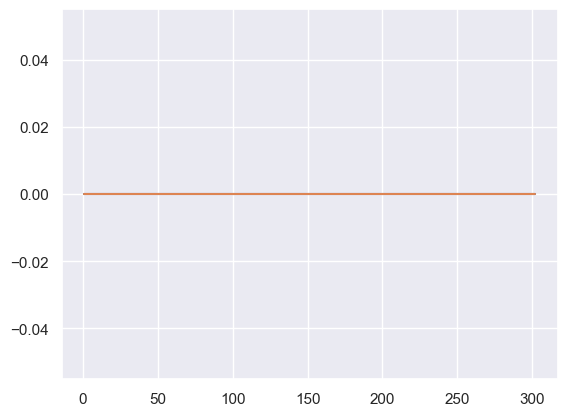

In [307]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
med_id = df_pct_chg_features.loc[5000]['mediabase_id']
call_letters = df_pct_chg_features.loc[5000]['call_letters']
mask = (df_pct_chg_features['mediabase_id'] == med_id) & (df_pct_chg_features['call_letters'] == call_letters) & (df_pct_chg_features['weeks_since_hit'] > 0)
df_sub = df_pct_chg_features.loc[mask]
scaler = StandardScaler()

for wk in [1]:
    col_name = f'song_station_ddl_{wk}wk_lag1_max_pct_chg'
    col_name_spins = f'song_station_spins_non_on_{wk}wk_lag1_mean_pct_chg'
    scaler.fit(df_sub[[col_name_spins]])
    df_sub[col_name_spins] = scaler.transform(df_sub[[col_name_spins]])
    print(col_name)
    plt.plot(df_sub['weeks_since_hit'], df_sub[col_name])
    plt.plot(df_sub['weeks_since_hit'], df_sub[col_name_spins])

In [306]:
df_sub

,mediabase_id,call_letters,week_dt,weeks_since_hit,artist_format_ddl_1wk_lag2_min_pct_chg,artist_format_ddl_1wk_lag4_mean_pct_chg,song_format_pop_1wk_lag2_mean_pct_chg,count_song_format_pop_1wk_lag2_max_pct_chg,song_station_pop_1wk_lag2_mean_pct_chg,song_station_ddl_1wk_lag3_mean_pct_chg,...,song_station_spins_non_on_1wk_lag4_sum_pct_chg,song_format_spins_non_on_1wk_lag1_mean_pct_chg,artist_station_spins_am_pm_dr_1wk_lag3_sum_pct_chg,artist_station_spins_non_on_1wk_lag2_min_pct_chg,artist_format_spins_non_on_1wk_lag4_min_pct_chg,song_market_spins_non_on_1wk_lag1_max_pct_chg,song_market_spins_non_on_1wk_lag1_mean_pct_chg,artist_station_spins_am_pm_dr_1wk_lag2_min_pct_chg,artist_station_spins_non_on_1wk_lag3_sum_pct_chg,artist_market_spins_am_pm_dr_1wk_lag3_max_pct_chg
803,2211649,WDCG-FM,2017-10-29,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
804,2211649,WDCG-FM,2017-11-05,2.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
805,2211649,WDCG-FM,2017-11-12,3.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
806,2211649,WDCG-FM,2017-11-19,4.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
807,2211649,WDCG-FM,2017-11-26,5.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1081,2211649,WDCG-FM,2023-02-26,279.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1082,2211649,WDCG-FM,2023-03-05,280.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1083,2211649,WDCG-FM,2023-03-12,281.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1084,2211649,WDCG-FM,2023-03-19,282.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [89]:
df_pct_chg_features

,mediabase_id,call_letters,week_dt,weeks_since_hit,song_format_fav_1wk_lag1_max_pct_chg,count_artist_format_pop_1wk_lag2_max_pct_chg,song_station_pop_1wk_lag2_mean_pct_chg,count_song_format_pop_1wk_lag3_mean_pct_chg,count_artist_format_pop_1wk_lag3_max_pct_chg,artist_format_ddl_1wk_lag3_min_pct_chg,...,artist_format_spins_non_on_1wk_lag3_max_pct_chg,song_format_spins_non_on_1wk_lag4_min_pct_chg,song_format_spins_non_on_1wk_lag3_sum_pct_chg,song_station_spins_non_on_1wk_lag3_max_pct_chg,artist_market_spins_non_on_1wk_lag2_min_pct_chg,song_station_spins_non_on_1wk_lag1_sum_pct_chg,song_market_spins_am_pm_dr_1wk_lag3_max_pct_chg,song_format_spins_am_pm_dr_1wk_lag3_mean_pct_chg,artist_station_spins_am_pm_dr_1wk_lag3_mean_pct_chg,artist_station_spins_non_on_1wk_lag1_mean_pct_chg
0,1086587,KHTS-FM,2022-06-12,-19.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,1086587,KHTS-FM,2022-06-19,-18.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,1086587,KHTS-FM,2022-06-26,-17.0,-0.133333,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.454545,0.000000,0.000000,0.000000,0.454545
3,1086587,KHTS-FM,2022-07-03,-16.0,0.000000,5.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.377778,0.187500,0.000000,0.000000,0.000000,0.187500
4,1086587,KHTS-FM,2022-07-10,-15.0,-0.038462,0.000000,0.000000,5.000000,5.000000,1.000000,...,1.963892,0.000000,1.963892,0.454545,0.161290,0.631579,0.318182,1.814093,0.000000,0.631579
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
656334,2865765,WZFT-FM,2023-02-26,3.0,0.250000,-0.421053,0.000000,0.666667,0.583333,0.000000,...,0.147008,0.223988,0.183802,0.075758,0.012579,0.052632,0.126984,0.213575,0.125000,0.287234
656335,2865765,WZFT-FM,2023-03-05,4.0,-0.066667,0.545455,0.000000,-0.400000,-0.421053,0.000000,...,0.087550,0.183802,0.106647,0.070423,0.124224,0.137500,-0.042254,0.125234,0.074074,0.314050
656336,2865765,WZFT-FM,2023-03-12,5.0,-0.035714,-0.117647,0.000000,0.555556,0.545455,0.285714,...,0.101049,0.106647,0.131620,0.052632,0.287293,0.065934,0.044118,0.146307,0.431034,-0.050314
656337,2865765,WZFT-FM,2023-03-19,6.0,-0.074074,0.533333,-0.085366,-0.142857,-0.117647,-0.111111,...,0.108622,0.131620,0.135141,0.137500,-0.008584,-0.061856,0.183099,0.130978,0.361446,-0.105960


In [37]:
df_temp_features.to_pickle('ebw_temp_features_with_chg_h1.pkl')

##### A/B/C Classfn

In [40]:
query_abc_classfn ='''
SELECT
    essch.*, eh.category
FROM
    adds_temp.ebw_song_station_calendar_h1 AS essch
     join adds_temp.ebw_abc_status_tracker_with_end_h1 as eh
    on eh.call_letters=essch.call_letters
    and eh.mediabase_id=essch.mediabase_id
    and essch.week_dt >= eh.assignment_date
    and essch.week_dt <= eh.assignment_date_end
where extract(year from essch.song_release_date) >= 2020
and song_release_date <= '2022-05-31'
'''

with engine.connect() as conn:
    with conn.begin():
        df_abc_classfn = pd.read_sql(query_abc_classfn, conn)

In [41]:
df_abc_classfn['week_dt'] = pd.to_datetime(df_abc_classfn['week_dt'])

In [42]:
df_abc_classfn = df_abc_classfn.join(df_raw_features.set_index(['call_letters', 'mediabase_id', 'week_dt'])['weeks_since_hit'], on=['call_letters', 'mediabase_id', 'week_dt'], how='left')

In [43]:
df_abc_classfn.sort_values(by=['call_letters', 'mediabase_id', 'week_dt'], inplace=True)

In [44]:
df_abc_classfn['category_new'] = df_abc_classfn['category'].apply(lambda x: x if x in ['A', 'B', 'C', 'D'] else 'Other')

In [50]:
df_classfn_ratios = df_abc_classfn[df_abc_classfn['weeks_since_hit'] > 0].groupby(['weeks_since_hit', 'category_new'])['mediabase_id'].count()/(df_abc_classfn[df_abc_classfn['weeks_since_hit'] > 0].groupby(['weeks_since_hit'])['mediabase_id'].count())

In [55]:
df_classfn_ratios_pvt = df_classfn_ratios.reset_index().pivot_table(index=['weeks_since_hit'], columns=['category_new'], values=['mediabase_id'])

In [57]:
df_classfn_ratios_pvt.columns = ['A', 'B', 'C', 'D', 'Other']

In [77]:
df_classfn_ratios_pvt.fillna(0, inplace=True)

In [61]:
df_classfn_ratios_pvt.index

Float64Index([  1.0,   2.0,   3.0,   4.0,   5.0,   6.0,   7.0,   8.0,   9.0,
               10.0,
              ...
              141.0, 142.0, 143.0, 144.0, 145.0, 146.0, 147.0, 148.0, 149.0,
              150.0],
             dtype='float64', name='weeks_since_hit', length=150)

In [84]:
df_classfn_ratios_pvt.index

Float64Index([  1.0,   2.0,   3.0,   4.0,   5.0,   6.0,   7.0,   8.0,   9.0,
               10.0,
              ...
              141.0, 142.0, 143.0, 144.0, 145.0, 146.0, 147.0, 148.0, 149.0,
              150.0],
             dtype='float64', name='weeks_since_hit', length=150)

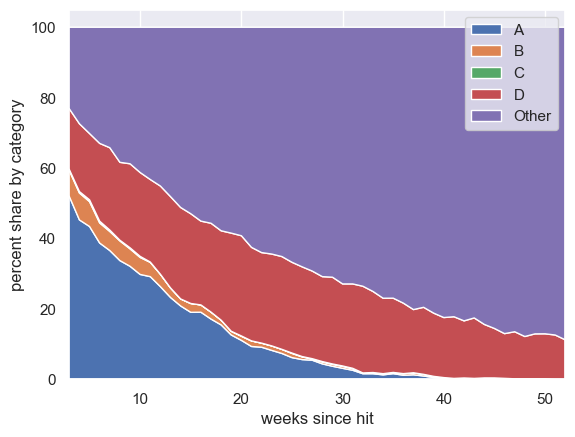

In [89]:
import matplotlib.pyplot as plt
plt.stackplot(df_classfn_ratios_pvt.index.values, 100*df_classfn_ratios_pvt.to_numpy().T, baseline='zero', labels=['A', 'B', 'C', 'D', 'Other'])
plt.xlim([3, 52])
plt.xlabel('weeks since hit')
plt.ylabel('percent share by category')
plt.legend()
plt.savefig('abc_share_h1.jpeg', format='jpeg', dpi=300)

In [70]:
 df_classfn_ratios_pvt.to_numpy()

array([[0.45893224, 0.10882957, 0.00616016, 0.13963039, 0.28644764],
       [0.53869654, 0.0712831 , 0.00509165, 0.16191446, 0.22301426],
       [0.51938776, 0.07346939, 0.00306122, 0.17244898, 0.23163265],
       [0.45259939, 0.0764526 , 0.00407747, 0.19266055, 0.27420999],
       [0.43398158, 0.07062436, 0.00511771, 0.18833163, 0.30194473],
       [0.38696538, 0.05702648, 0.00509165, 0.2209776 , 0.3299389 ],
       [0.36567926, 0.05413687, 0.0040858 , 0.23391216, 0.3421859 ],
       [0.33705584, 0.05583756, 0.00203046, 0.2213198 , 0.38375635],
       [0.32098765, 0.04938272, 0.00308642, 0.23868313, 0.38786008],
       [0.29774127, 0.04825462, 0.00308008, 0.23819302, 0.41273101],
       [0.29149378, 0.04045643, 0.00103734, 0.23443983, 0.43257261],
       [0.26299376, 0.03534304,        nan, 0.25051975, 0.45114345],
       [0.23229167, 0.02708333,        nan, 0.259375  , 0.48125   ],
       [0.20820189, 0.01997897,        nan, 0.2597266 , 0.51209253],
       [0.19017764, 0.02507837,   

In [47]:
df_abc_classfn[['call_letters', 'mediabase_id']].drop_duplicates()

,call_letters,mediabase_id
25,KBKS-FM,2256903
2142,KBKS-FM,2570716
2294,KBKS-FM,2580292
2628,KBKS-FM,2583267
3132,KBKS-FM,2584541
...,...,...
76507,WZFT-FM,2750191
76509,WZFT-FM,2754544
98886,WZFT-FM,2794968
98952,WZFT-FM,2797282
